# 속도 데이터 분석 및 벡터 변환

In [1]:
# 6D rotation → Euler angles 변환 함수
import os
import glob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

np.set_printoptions(threshold=np.inf, linewidth=200, suppress=True)

import torch
from common.quaternion import cont6d_to_matrix_np, matrix_to_quat, qeuler_np

## 1. 6D rotation에서 오일러 각도로 변환

In [2]:
def convert_6d_to_euler(rot_data_6d, order='xyz'):
    """
    6D rotation representation을 오일러 각도로 변환
    
    Args:
        rot_data_6d: (seq_len, 126) 또는 (seq_len, 21, 6) 형태의 6D rotation 데이터
        order: 오일러 각도 순서 ('xyz', 'zyx' 등)
    
    Returns:
        euler_angles: (seq_len, 21, 3) 형태의 오일러 각도 (degree)
    """
    # 1. 입력 형태 확인 및 변환
    if len(rot_data_6d.shape) == 2:
        # (seq_len, 126) → (seq_len, 21, 6)
        rot_data_6d = rot_data_6d.reshape(-1, 21, 6)
    
    # 2. 6D → Rotation Matrix
    rot_matrix = cont6d_to_matrix_np(rot_data_6d)  # (seq_len, 21, 3, 3)
    
    # 3. Rotation Matrix → Quaternion
    rot_matrix_torch = torch.from_numpy(rot_matrix).float()
    quat = matrix_to_quat(rot_matrix_torch).numpy()  # (seq_len, 21, 4)
    
    # 4. Quaternion → Euler Angles
    euler_angles_deg = qeuler_np(quat, order=order)  # (seq_len, 21, 3) # degree
    euler_angles_rad = np.deg2rad(euler_angles_deg)      # rad

    return euler_angles_deg, euler_angles_rad

#### 단일 파일 테스트

In [ ]:
# 단일 파일 오일러 각도 변환 및 저장
file_name = "sh281.npy"

# 파일 경로 설정
input_file = 'D:/HumanML3D-SMPL-main/HumanML3D/test_input/' + file_name
output_file = 'D:/HumanML3D-SMPL-main/HumanML3D/test_output/' + file_name

# 출력 폴더 생성
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# 데이터 로드
data = np.load(input_file)  # (seq_len, 263)
print(f"입력 데이터 shape: {data.shape}")

# rot_data 추출 (67:193 = 126차원)
rot_data_6d = data[..., 67:193]  # (seq_len, 126)
print(f"6D rotation shape: {rot_data_6d.shape}")

# 6D → Euler 변환
euler_angles_deg, euler_angles_rad = convert_6d_to_euler(rot_data_6d, order='xyz')
print(f"Euler angles shape: {euler_angles_deg.shape}")

# 저장
np.save(output_file, euler_angles_deg)
print(f"\n저장 완료: {output_file}")

# 통계 출력
print(f"\n=== 통계 (degree) ===")
print(f"Min: {euler_angles_deg.min():.3f}°")
print(f"Max: {euler_angles_deg.max():.3f}°")
print(f"Mean: {euler_angles_deg.mean():.3f}°")
print(f"Std: {euler_angles_deg.std():.3f}°")

입력 데이터 shape: (32, 263)
6D rotation shape: (32, 126)
Euler angles shape: (32, 21, 3)

저장 완료: D:/HumanML3D-SMPL-main/HumanML3D/test_output/sh281.npy

=== 통계 (degree) ===
Min: -128.099°
Max: 122.288°
Mean: -3.144°
Std: 36.683°


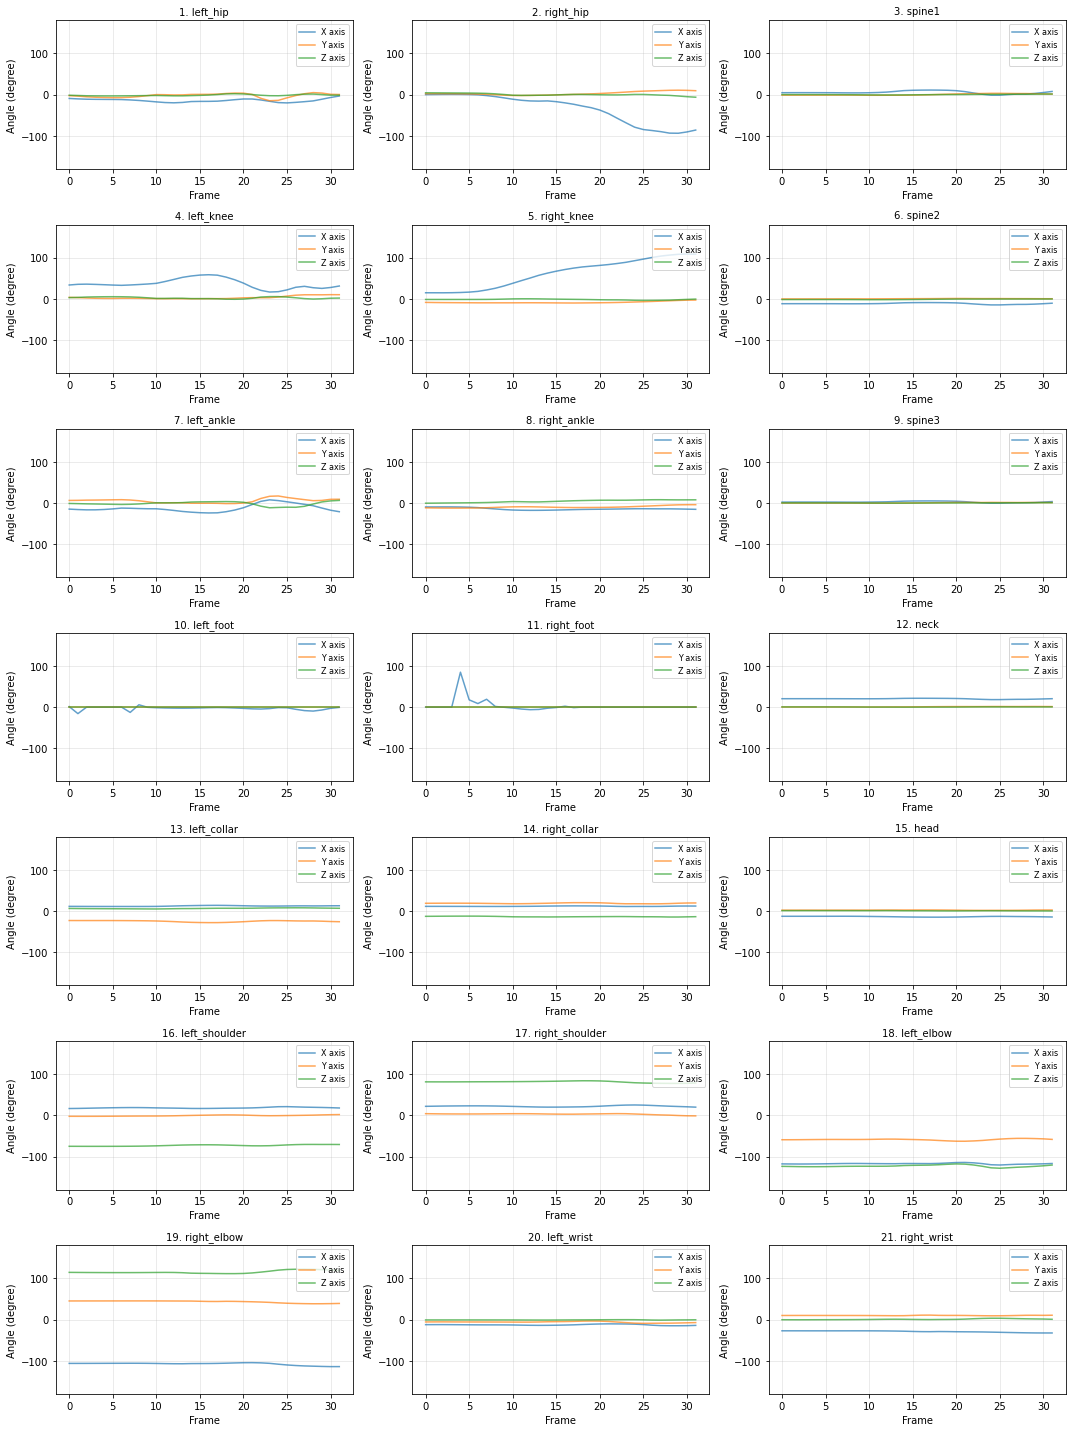

In [64]:
# 오일러 각도 파일 플롯
file_path = 'D:/HumanML3D-SMPL-main/HumanML3D/test_output/' + file_name

# 데이터 로드
euler_angles = np.load(file_path)  # (seq_len, 21, 3)
seq_len, num_joints, _ = euler_angles.shape

# 관절 이름
joint_names = [
    "left_hip",       # 1
    "right_hip",      # 2
    "spine1",         # 3
    "left_knee",      # 4
    "right_knee",     # 5
    "spine2",         # 6
    "left_ankle",     # 7
    "right_ankle",    # 8
    "spine3",         # 9
    "left_foot",      # 10
    "right_foot",     # 11
    "neck",           # 12
    "left_collar",    # 13
    "right_collar",   # 14
    "head",           # 15
    "left_shoulder",  # 16
    "right_shoulder", # 17
    "left_elbow",     # 18
    "right_elbow",    # 19
    "left_wrist",     # 20
    "right_wrist"     # 21
]

# Figure 생성 (7행 3열 = 21개 관절)
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
axes = axes.flatten()

# 각 관절별로 플롯
for joint_idx in range(num_joints):
    ax = axes[joint_idx]
    
    # X, Y, Z축 각도 플롯
    ax.plot(euler_angles[:, joint_idx, 0], label='X axis', alpha=0.7)
    ax.plot(euler_angles[:, joint_idx, 1], label='Y axis', alpha=0.7)
    ax.plot(euler_angles[:, joint_idx, 2], label='Z axis', alpha=0.7)
    
    ax.set_title(f'{joint_idx+1}. {joint_names[joint_idx]}', fontsize=10)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Angle (degree)')
    ax.set_ylim(-180, 180)  # Y축 범위 고정
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. 오일러 각도를 차분하여 각속도 계산 및 저장

### 2-1. 개별 파일 각속도 계산 및 저장

In [138]:
# 단일 파일 각속도 계산 및 저장

# 파일 경로 설정
input_file = 'D:/HumanML3D-SMPL-main/HumanML3D/test_output/' + file_name  # 오일러 각도 파일
output_file = 'D:/HumanML3D-SMPL-main/HumanML3D/test_angular_velocity/' + file_name  # 각속도 저장 파일

# 출력 폴더 생성
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# 오일러 각도 로드
euler_angles = np.load(input_file)  # (seq_len, 21, 3)
print(f"입력 오일러 각도 shape: {euler_angles.shape}")

# 각속도 계산 (차분)
angular_velocity = np.diff(euler_angles, axis=0)  # (seq_len-1, 21, 3)
print(f"각속도 shape: {angular_velocity.shape}")

# 저장
np.save(output_file, angular_velocity)
print(f"\n저장 완료: {output_file}")

# 통계 출력
print(f"\n=== 각속도 통계 (degree/frame) ===")
print(f"Min: {angular_velocity.min():.3f}°/frame")
print(f"Max: {angular_velocity.max():.3f}°/frame")
print(f"Mean: {angular_velocity.mean():.3f}°/frame")
print(f"Std: {angular_velocity.std():.3f}°/frame")

입력 오일러 각도 shape: (44, 21, 3)
각속도 shape: (43, 21, 3)

저장 완료: D:/HumanML3D-SMPL-main/HumanML3D/test_angular_velocity/sp204.npy

=== 각속도 통계 (degree/frame) ===
Min: -93.173°/frame
Max: 95.438°/frame
Mean: 0.001°/frame
Std: 2.689°/frame


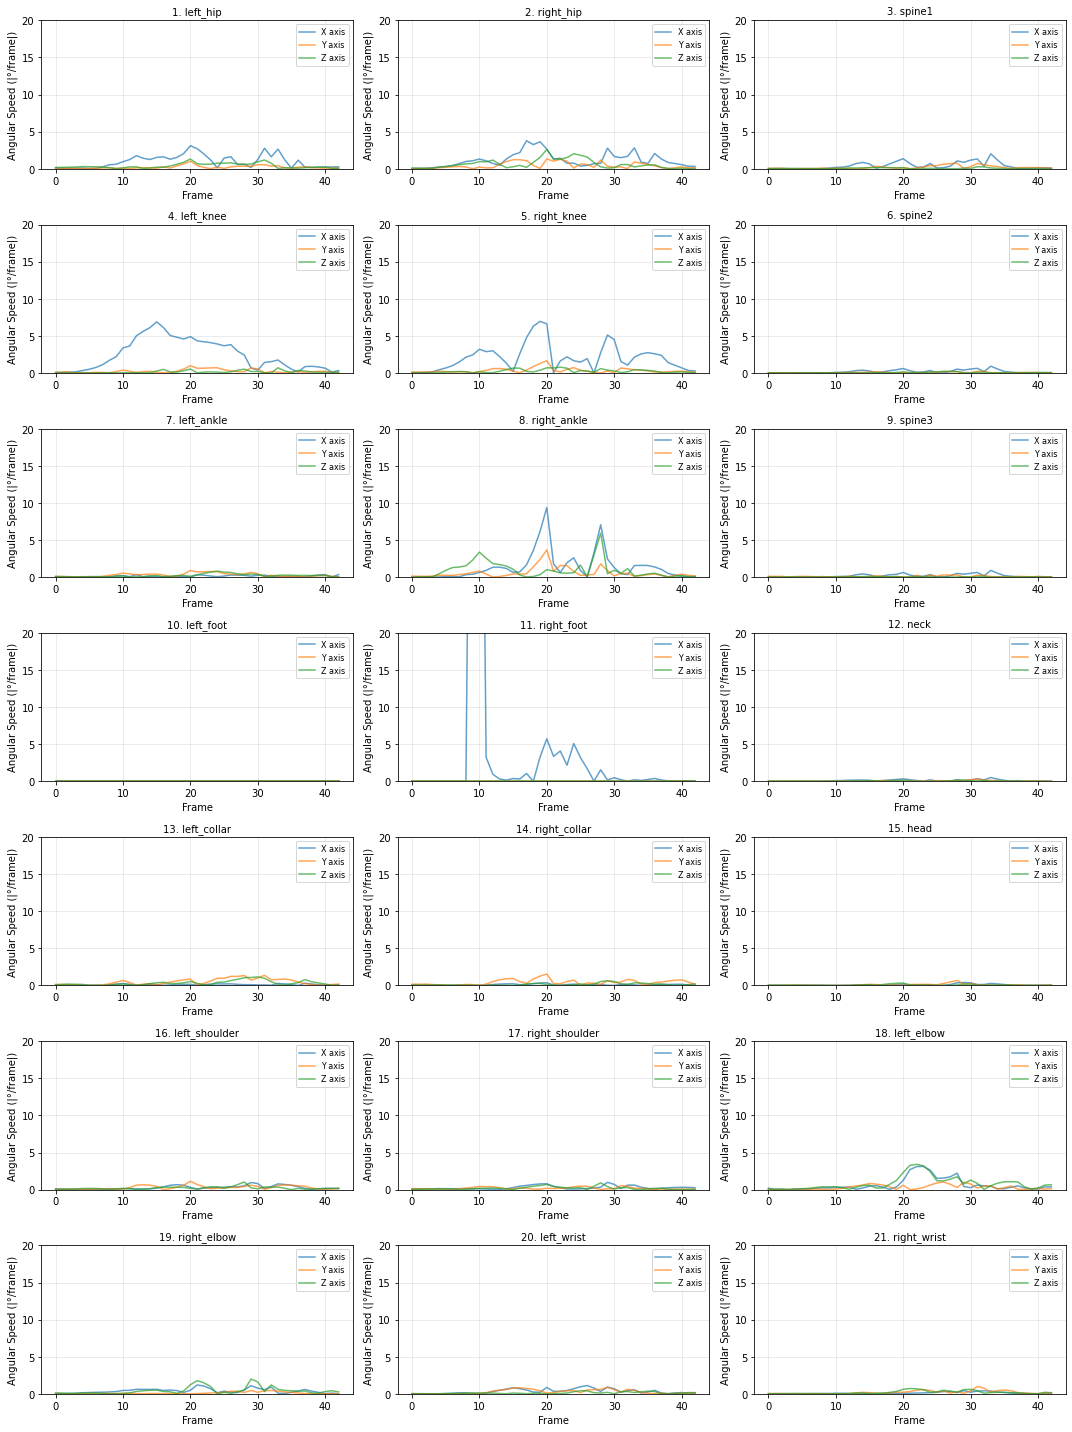

In [139]:
# 각속도 파일 플롯
file_path = 'D:/HumanML3D-SMPL-main/HumanML3D/test_angular_velocity/' + file_name

# 데이터 로드
angular_velocity = np.load(file_path)  # (seq_len-1, 21, 3)
seq_len, num_joints, _ = angular_velocity.shape

# 절대값으로 변환 (플롯용)
angular_velocity_abs = np.abs(angular_velocity)

# 관절 이름
joint_names = [
    "left_hip",       # 1
    "right_hip",      # 2
    "spine1",         # 3
    "left_knee",      # 4
    "right_knee",     # 5
    "spine2",         # 6
    "left_ankle",     # 7
    "right_ankle",    # 8
    "spine3",         # 9
    "left_foot",      # 10
    "right_foot",     # 11
    "neck",           # 12
    "left_collar",    # 13
    "right_collar",   # 14
    "head",           # 15
    "left_shoulder",  # 16
    "right_shoulder", # 17
    "left_elbow",     # 18
    "right_elbow",    # 19
    "left_wrist",     # 20
    "right_wrist"     # 21
]

# Figure 생성 (7행 3열 = 21개 관절)
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
axes = axes.flatten()

# 고정된 범위 사용 (0부터 시작)
FIXED_MIN = 0.0    # 절대값이므로 0부터
FIXED_MAX = 20.0   # 원하는 최대값

# 플롯 부분에서
for joint_idx in range(num_joints):
    ax = axes[joint_idx]
    
    # 절대값으로 플롯
    ax.plot(angular_velocity_abs[:, joint_idx, 0], label='X axis', alpha=0.7)
    ax.plot(angular_velocity_abs[:, joint_idx, 1], label='Y axis', alpha=0.7)
    ax.plot(angular_velocity_abs[:, joint_idx, 2], label='Z axis', alpha=0.7)
    
    ax.set_title(f'{joint_idx+1}. {joint_names[joint_idx]}', fontsize=10)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Angular Speed (|°/frame|)')  # 라벨도 변경
    ax.set_ylim(FIXED_MIN, FIXED_MAX)  # 고정 범위 사용
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2-2. 전체 파일 각속도 계산 및 저장. 앞의 단일 파일을 건너뛰고 여기부터 실행하면 됨

In [3]:
# 전체 파일에 대해 오일러 각도 차분값 계산 및 저장
input_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/new_joint_vecs'
euler_output_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/01_euler_angles'
velocity_output_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity'

# 출력 폴더 생성
os.makedirs(euler_output_dir, exist_ok=True)
os.makedirs(velocity_output_dir, exist_ok=True)

# 입력 파일 목록 가져오기
input_files = sorted(glob.glob(os.path.join(input_dir, '*.npy')))
print(f"총 {len(input_files)}개 파일 발견")

# 전체 파일 처리
for input_file in tqdm(input_files, desc="Processing files"):
    # 파일명 추출
    filename = os.path.basename(input_file)
    
    # 출력 파일 경로
    euler_output_file = os.path.join(euler_output_dir, filename)
    velocity_output_file = os.path.join(velocity_output_dir, filename)
    
    try:
        # 1. 데이터 로드
        data = np.load(input_file)  # (seq_len, 263)
        
        # 2. rot_data 추출 (67:193 = 126차원)
        rot_data_6d = data[..., 67:193]  # (seq_len, 126)
        
        # 3. 6D → Euler 변환
        euler_angles_deg, _ = convert_6d_to_euler(rot_data_6d, order='xyz') # (seq_len, 21, 3)
        
        # 4. 오일러 각도 저장
        np.save(euler_output_file, euler_angles_deg)
        
        # 5. 각속도 계산 (차분)
        angular_velocity = np.diff(euler_angles_deg, axis=0)  # (seq_len-1, 21, 3)
        
        # 6. 각속도 저장
        np.save(velocity_output_file, angular_velocity)
        
    except Exception as e:
        print(f"\n오류 발생 - {filename}: {e}")

print(f"\n처리 완료!")
print(f"오일러 각도 저장 위치: {euler_output_dir}")
print(f"각속도 저장 위치: {velocity_output_dir}")

Processing files:   1%|          | 12/1584 [00:00<00:13, 115.93it/s]

총 1584개 파일 발견


Processing files: 100%|██████████| 1584/1584 [00:14<00:00, 110.76it/s]


처리 완료!
오일러 각도 저장 위치: D:/HumanML3D-SMPL-main/HumanML3D/01_euler_angles
각속도 저장 위치: D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity


## 3. 전체 각속도 데이터의 max값과 min값 찾기

- 관절별
- 전체 관절별

In [4]:
# 전체 각속도 데이터의 min/max 찾기
velocity_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity'

# 모든 각속도 파일 가져오기
velocity_files = sorted(glob.glob(os.path.join(velocity_dir, '*.npy')))
print(f"총 {len(velocity_files)}개 파일 분석")

# 관절별 min/max 초기화 (21개 관절, 3개 축)
joint_min = np.full((21, 3), np.inf)   # 각 관절의 최소값
joint_max = np.full((21, 3), -np.inf)  # 각 관절의 최대값

# 전역 min/max 초기화
global_min = np.inf
global_max = -np.inf

# 모든 파일 순회
for velocity_file in tqdm(velocity_files, desc="Finding min/max"):
    try:
        # 각속도 데이터 로드
        angular_velocity = np.load(velocity_file)  # (seq_len-1, 21, 3)
        
        # 관절별 min/max 업데이트
        for joint_idx in range(21):
            for axis_idx in range(3):
                joint_data = angular_velocity[:, joint_idx, axis_idx]
                joint_min[joint_idx, axis_idx] = min(joint_min[joint_idx, axis_idx], joint_data.min())
                joint_max[joint_idx, axis_idx] = max(joint_max[joint_idx, axis_idx], joint_data.max())
        
        # 전역 min/max 업데이트
        global_min = min(global_min, angular_velocity.min())
        global_max = max(global_max, angular_velocity.max())
        
    except Exception as e:
        print(f"\n오류 발생 - {os.path.basename(velocity_file)}: {e}")

print(f"\n=== 전역 통계 ===")
print(f"전역 Min: {global_min:.6f}°/frame")
print(f"전역 Max: {global_max:.6f}°/frame")
print(f"전역 Range: {global_max - global_min:.6f}°/frame")

Finding min/max:   1%|          | 12/1584 [00:00<00:13, 114.78it/s]

총 1584개 파일 분석


Finding min/max: 100%|██████████| 1584/1584 [00:16<00:00, 96.54it/s] 


=== 전역 통계 ===
전역 Min: -359.823303°/frame
전역 Max: 359.950409°/frame
전역 Range: 719.773682°/frame


In [5]:
# 관절별 min/max 상세 출력

joint_names = [
    "left_hip", "right_hip", "spine1", "left_knee", "right_knee",
    "spine2", "left_ankle", "right_ankle", "spine3", "left_foot",
    "right_foot", "neck", "left_collar", "right_collar", "head",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist"
]

axis_names = ['X', 'Y', 'Z']

print("\n=== 관절별 Min/Max (degree/frame) ===")
print(f"{'Joint':<20} {'Axis':<5} {'Min':>12} {'Max':>12} {'Range':>12}")
print("-" * 65)

for joint_idx in range(21):
    for axis_idx in range(3):
        min_val = joint_min[joint_idx, axis_idx]
        max_val = joint_max[joint_idx, axis_idx]
        range_val = max_val - min_val
        
        joint_name = joint_names[joint_idx] if axis_idx == 0 else ""
        print(f"{joint_name:<20} {axis_names[axis_idx]:<5} {min_val:>12.6f} {max_val:>12.6f} {range_val:>12.6f}")

# 통계 저장
stats = {
    'global_min': global_min,
    'global_max': global_max,
    'joint_min': joint_min,  # (21, 3)
    'joint_max': joint_max   # (21, 3)
}

stats_file = 'D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity/angular_velocity_stats.npz'
np.savez(stats_file, **stats)
print(f"\n통계 저장 완료: {stats_file}")


=== 관절별 Min/Max (degree/frame) ===
Joint                Axis           Min          Max        Range
-----------------------------------------------------------------
left_hip             X       -61.774502    72.253113   134.027615
                     Y       -39.390678    38.475456    77.866135
                     Z       -32.148857    40.251572    72.400429
right_hip            X       -61.774502    72.253113   134.027615
                     Y       -38.475456    39.390678    77.866135
                     Z       -40.251572    32.148857    72.400429
spine1               X       -46.283760    53.920277   100.204037
                     Y       -20.069492    20.069492    40.138985
                     Z       -44.478268    44.478268    88.956535
left_knee            X      -113.563744    91.517838   205.081581
                     Y       -73.537354    43.635445   117.172798
                     Z       -71.596130    53.584198   125.180328
right_knee           X      -113.563744 

## 4. 각속도 정규화 (0~1 범위)

- normalization후 다시 최종 파일 저장

### 3-1. 대칭 관절을 고려하지 않은 정규화

In [ ]:
# 전체 각속도 데이터를 관절별로 정규화

# 통계 파일 로드
stats_file = 'D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity/angular_velocity_stats.npz'
stats = np.load(stats_file)
joint_min = stats['joint_min']  # (21, 3)
joint_max = stats['joint_max']  # (21, 3)

print("통계 로드 완료")
print(f"joint_min shape: {joint_min.shape}")
print(f"joint_max shape: {joint_max.shape}")

# 디렉토리 설정
velocity_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity'
normalized_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/03_angular_velocity_normalized'

# 출력 폴더 생성
os.makedirs(normalized_dir, exist_ok=True)

# 모든 각속도 파일 가져오기
velocity_files = sorted(glob.glob(os.path.join(velocity_dir, '*.npy')))
print(f"\n총 {len(velocity_files)}개 파일 정규화 시작")

# 모든 파일 정규화
for velocity_file in tqdm(velocity_files, desc="Normalizing"):
    try:
        # 파일명 추출
        filename = os.path.basename(velocity_file)
        output_file = os.path.join(normalized_dir, filename)
        
        # 각속도 데이터 로드
        angular_velocity = np.load(velocity_file)  # (seq_len-1, 21, 3)
        
        # 정규화 수행 (관절별, 축별)
        normalized = np.zeros_like(angular_velocity)
        for joint_idx in range(21):
            for axis_idx in range(3):
                min_val = joint_min[joint_idx, axis_idx]
                max_val = joint_max[joint_idx, axis_idx]
                
                # Min-Max Normalization: [min, max] → [0, 1]
                normalized[:, joint_idx, axis_idx] = \
                    (angular_velocity[:, joint_idx, axis_idx] - min_val) / (max_val - min_val)
        
        # 저장
        np.save(output_file, normalized)
        
    except Exception as e:
        print(f"\n오류 발생 - {filename}: {e}")

print(f"\n정규화 완료!")
print(f"저장 위치: {normalized_dir}")

# 샘플 검증
sample_file = velocity_files[0]
sample_normalized = np.load(os.path.join(normalized_dir, os.path.basename(sample_file)))
print(f"\n샘플 파일 검증: {os.path.basename(sample_file)}")
print(f"정규화된 데이터 범위: [{sample_normalized.min():.6f}, {sample_normalized.max():.6f}]")

Normalizing:   0%|          | 99/29228 [00:00<00:29, 984.94it/s]

통계 로드 완료
joint_min shape: (21, 3)
joint_max shape: (21, 3)

총 29228개 파일 정규화 시작


Normalizing: 100%|██████████| 29228/29228 [02:02<00:00, 238.02it/s]  


정규화 완료!
저장 위치: D:/HumanML3D-SMPL-main/HumanML3D/angular_velocity_normalized

샘플 파일 검증: 000000.npy
정규화된 데이터 범위: [0.281415, 0.705876]


### 3-2. 대칭 관절을 고려한 정규화. 이걸 사용하자

In [6]:
# 대칭 관절을 고려한 정규화

# 통계 파일 로드
stats_file = 'D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity/angular_velocity_stats.npz'
stats = np.load(stats_file)
joint_min = stats['joint_min'].copy()  # (21, 3)
joint_max = stats['joint_max'].copy()  # (21, 3)

print("원본 통계 로드 완료")

# 대칭 관절 쌍 정의 (인덱스 기준, 0-based)
symmetric_pairs = [
    (0, 1),    # right_hip (0) ↔ left_hip (1)
    (3, 4),    # right_knee (3) ↔ left_knee (4)
    (6, 7),    # right_ankle (6) ↔ left_ankle (7)
    (9, 10),   # right_foot (9) ↔ left_foot (10)
    (12, 13),  # right_collar (12) ↔ left_collar (13)
    (15, 16),  # right_shoulder (15) ↔ left_shoulder (16)
    (17, 18),  # right_elbow (17) ↔ left_elbow (18)
    (19, 20),  # right_wrist (19) ↔ left_wrist (20)
]

# 대칭 관절끼리 min/max 통합
for left_idx, right_idx in symmetric_pairs:
    for axis_idx in range(3):
        # 두 관절의 min 중 더 작은 값 사용
        combined_min = min(joint_min[left_idx, axis_idx], joint_min[right_idx, axis_idx])
        # 두 관절의 max 중 더 큰 값 사용
        combined_max = max(joint_max[left_idx, axis_idx], joint_max[right_idx, axis_idx])
        
        # 양쪽 관절에 동일한 값 적용
        joint_min[left_idx, axis_idx] = combined_min
        joint_min[right_idx, axis_idx] = combined_min
        joint_max[left_idx, axis_idx] = combined_max
        joint_max[right_idx, axis_idx] = combined_max

print("대칭 관절 통합 완료")

# 디렉토리 설정
velocity_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity'
normalized_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/03_angular_velocity_normalized'

# 출력 폴더 생성
os.makedirs(normalized_dir, exist_ok=True)

# 모든 각속도 파일 가져오기
velocity_files = sorted(glob.glob(os.path.join(velocity_dir, '*.npy')))
print(f"\n총 {len(velocity_files)}개 파일 정규화 시작")

# 모든 파일 정규화
for velocity_file in tqdm(velocity_files, desc="Normalizing with symmetric joints"):
    try:
        # 파일명 추출
        filename = os.path.basename(velocity_file)
        output_file = os.path.join(normalized_dir, filename)
        
        # 각속도 데이터 로드
        angular_velocity = np.load(velocity_file)  # (seq_len-1, 21, 3)
        
        # 정규화 수행 (관절별, 축별)
        normalized = np.zeros_like(angular_velocity)
        for joint_idx in range(21):
            for axis_idx in range(3):
                min_val = joint_min[joint_idx, axis_idx]
                max_val = joint_max[joint_idx, axis_idx]
                
                # Min-Max Normalization: [min, max] → [0, 1]
                normalized[:, joint_idx, axis_idx] = \
                    (angular_velocity[:, joint_idx, axis_idx] - min_val) / (max_val - min_val)
        
        # 저장
        np.save(output_file, normalized)
        
    except Exception as e:
        print(f"\n오류 발생 - {filename}: {e}")

print(f"\n정규화 완료!")
print(f"저장 위치: {normalized_dir}")

Normalizing with symmetric joints:   0%|          | 0/1584 [00:00<?, ?it/s]

Normalizing with symmetric joints:   3%|▎         | 54/1584 [00:00<00:02, 531.82it/s]

원본 통계 로드 완료
대칭 관절 통합 완료

총 1584개 파일 정규화 시작


Normalizing with symmetric joints: 100%|██████████| 1584/1584 [00:03<00:00, 502.88it/s]


정규화 완료!
저장 위치: D:/HumanML3D-SMPL-main/HumanML3D/03_angular_velocity_normalized


In [8]:
# 대칭 관절 검증
print("\n=== 대칭 관절 정규화 검증 ===")
test_original = np.load(os.path.join(velocity_dir, '0003_treadmill_jog_poses_timewarp_down2_keepfps.npy'))
test_mirrored = np.load(os.path.join(velocity_dir, '0003_treadmill_jog_poses_timewarp_down2_keepfps.npy'))
test_norm_original = np.load(os.path.join(normalized_dir, '0003_treadmill_jog_poses_timewarp_down2_keepfps.npy'))
test_norm_mirrored = np.load(os.path.join(normalized_dir, '0003_treadmill_jog_poses_timewarp_down2_keepfps.npy'))

print(f"0003_treadmill_jog_poses_timewarp_down2_keepfps.npy  정규화 범위: [{test_norm_original.min():.6f}, {test_norm_original.max():.6f}]  평균: {test_norm_original.mean():.6f}")
print(f"0003_treadmill_jog_poses_timewarp_down2_keepfps.npy 정규화 범위: [{test_norm_mirrored.min():.6f}, {test_norm_mirrored.max():.6f}]  평균: {test_norm_mirrored.mean():.6f}")


=== 대칭 관절 정규화 검증 ===
0003_treadmill_jog_poses_timewarp_down2_keepfps.npy  정규화 범위: [0.217292, 0.886327]  평균: 0.509126
0003_treadmill_jog_poses_timewarp_down2_keepfps.npy 정규화 범위: [0.217292, 0.886327]  평균: 0.509126


#### 정규화 후 개별 파일 검증

파일: 008194.npy
데이터 shape: (8, 21, 3)
전체 정규화 범위: [0.274645, 0.622737]
전체 평균: 0.503541

관절                          Min        Max       Mean        Std
left_hip               0.466978   0.514814   0.491403   0.012210
right_hip              0.481079   0.527527   0.505277   0.012863
spine1                 0.470410   0.556723   0.507674   0.024218
left_knee              0.430335   0.573773   0.503483   0.035516
right_knee             0.476364   0.521142   0.494874   0.011557
spine2                 0.418542   0.535261   0.493301   0.031830
left_ankle             0.483219   0.516693   0.497358   0.010706
right_ankle            0.469797   0.505373   0.494429   0.009151
spine3                 0.440818   0.539768   0.489906   0.030483
left_foot              0.494936   0.500000   0.498312   0.002387
right_foot             0.494936   0.500000   0.498312   0.002387
neck                   0.274645   0.622737   0.457353   0.070003
left_collar            0.476671   0.573011   0.523884   0.026458
righ

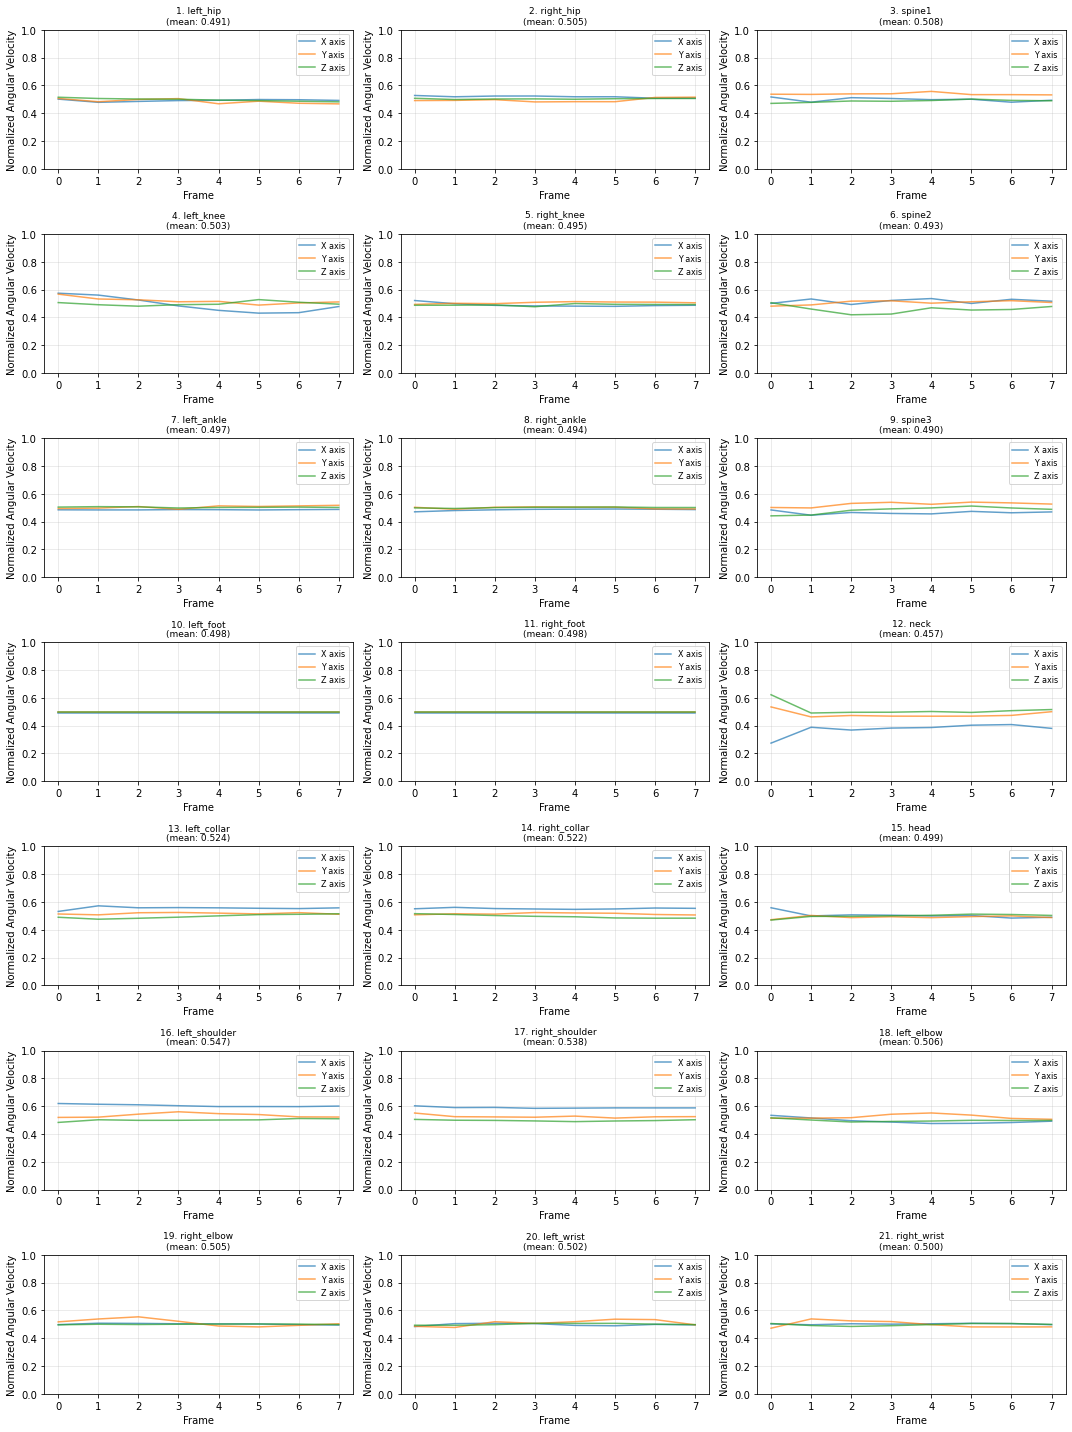

In [ ]:
# 정규화된 각속도 파일 플롯 (관절별 범위 출력 포함)
file_path = 'D:/HumanML3D-SMPL-main/HumanML3D/03_angular_velocity_normalized/000000.npy'

# 데이터 로드
normalized_velocity = np.load(file_path)  # (seq_len-1, 21, 3)
seq_len, num_joints, _ = normalized_velocity.shape

# 관절 이름
joint_names = [
    "left_hip",       # 1
    "right_hip",      # 2
    "spine1",         # 3
    "left_knee",      # 4
    "right_knee",     # 5
    "spine2",         # 6
    "left_ankle",     # 7
    "right_ankle",    # 8
    "spine3",         # 9
    "left_foot",      # 10
    "right_foot",     # 11
    "neck",           # 12
    "left_collar",    # 13
    "right_collar",   # 14
    "head",           # 15
    "left_shoulder",  # 16
    "right_shoulder", # 17
    "left_elbow",     # 18
    "right_elbow",    # 19
    "left_wrist",     # 20
    "right_wrist"     # 21
]

# 전체 데이터 범위 확인
print(f"파일: {os.path.basename(file_path)}")
print(f"데이터 shape: {normalized_velocity.shape}")
print(f"전체 정규화 범위: [{normalized_velocity.min():.6f}, {normalized_velocity.max():.6f}]")
print(f"전체 평균: {normalized_velocity.mean():.6f}\n")

# 관절별 상세 통계
print("="*80)
print(f"{'관절':<20} {'Min':>10} {'Max':>10} {'Mean':>10} {'Std':>10}")
print("="*80)

for joint_idx in range(num_joints):
    joint_data = normalized_velocity[:, joint_idx, :]  # (seq_len-1, 3)
    min_val = joint_data.min()
    max_val = joint_data.max()
    mean_val = joint_data.mean()
    std_val = joint_data.std()
    
    print(f"{joint_names[joint_idx]:<20} {min_val:>10.6f} {max_val:>10.6f} {mean_val:>10.6f} {std_val:>10.6f}")

# Figure 생성 (7행 3열 = 21개 관절)
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
axes = axes.flatten()

# 각 관절별로 플롯
for joint_idx in range(num_joints):
    ax = axes[joint_idx]
    
    joint_data = normalized_velocity[:, joint_idx, :]
    
    # X, Y, Z축 정규화된 각속도 플롯
    ax.plot(normalized_velocity[:, joint_idx, 0], label='X axis', alpha=0.7)
    ax.plot(normalized_velocity[:, joint_idx, 1], label='Y axis', alpha=0.7)
    ax.plot(normalized_velocity[:, joint_idx, 2], label='Z axis', alpha=0.7)
    
    # 제목에 통계 추가
    ax.set_title(f'{joint_idx+1}. {joint_names[joint_idx]}\n(mean: {joint_data.mean():.3f})', fontsize=9)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Normalized Angular Velocity')
    ax.set_ylim(0, 1)  # Y축 범위 0~1로 고정 (정규화됨)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 관절별로 가장 빠른/느린 동작 찾기

In [9]:
# 원본 각속도 데이터로 빠른/느린 동작 찾기
velocity_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity'

# 관절 이름
joint_names = [
    "left_hip", "right_hip", "spine1", "left_knee", "right_knee",
    "spine2", "left_ankle", "right_ankle", "spine3", "left_foot",
    "right_foot", "neck", "left_collar", "right_collar", "head",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist"
]

# 모든 원본 각속도 파일 가져오기
velocity_files = sorted(glob.glob(os.path.join(velocity_dir, '*.npy')))
print(f"총 {len(velocity_files)}개 파일 분석\n")

# 각 관절별로 파일 통계 수집
joint_file_stats = {}

for joint_idx in range(21):
    joint_file_stats[joint_idx] = []

for file_path in tqdm(velocity_files, desc="Analyzing per joint"):
    try:
        data = np.load(file_path)  # (seq_len-1, 21, 3)
        filename = os.path.basename(file_path)
        
        # 각 관절별 통계 계산
        for joint_idx in range(21):
            joint_data = data[:, joint_idx, :]  # (seq_len-1, 3)
            
            # 절대값의 평균 = 평균 속도 크기
            abs_mean = np.abs(joint_data).mean()
            
            # RMS (Root Mean Square) = 속도의 제곱 평균의 제곱근
            rms = np.sqrt((joint_data ** 2).mean())
            
            joint_file_stats[joint_idx].append({
                'filename': filename,
                'abs_mean': abs_mean,  # 절대값 평균
                'rms': rms,           # RMS
            })
            
    except Exception as e:
        print(f"\n오류: {os.path.basename(file_path)}: {e}")

# 각 관절별로 Top 5 가장 빠른/느린 파일 출력
import pandas as pd

for joint_idx in range(21):
    print(f"\n{'='*80}")
    print(f"관절 #{joint_idx+1}: {joint_names[joint_idx]}")
    print(f"{'='*80}")
    
    df = pd.DataFrame(joint_file_stats[joint_idx])
    
    # 가장 빠른 Top 5 (RMS 기준)
    print(f"\n[가장 빠른 동작 Top 5 - RMS 기준]")
    top_fast = df.nlargest(5, 'rms')
    for idx, row in top_fast.iterrows():
        print(f"  {row['filename']:<20} RMS: {row['rms']:>8.3f}°/frame  |절대값 평균|: {row['abs_mean']:>8.3f}°/frame")
    
    # 가장 느린 Top 5 (RMS 기준)
    print(f"\n[가장 느린 동작 Top 5 - RMS 기준]")
    top_slow = df.nsmallest(5, 'rms')
    for idx, row in top_slow.iterrows():
        print(f"  {row['filename']:<20} RMS: {row['rms']:>8.3f}°/frame  |절대값 평균|: {row['abs_mean']:>8.3f}°/frame")

Analyzing per joint:   8%|▊         | 119/1584 [00:00<00:01, 1184.72it/s]

총 1584개 파일 분석



Analyzing per joint: 100%|██████████| 1584/1584 [00:01<00:00, 1168.44it/s]



관절 #1: left_hip

[가장 빠른 동작 Top 5 - RMS 기준]
  Mg5 -  back kick_poses_timewarp_down2_keepfps.npy RMS:   13.665°/frame  |절대값 평균|:    7.524°/frame
  Mg3 - sidekick leading right_poses_timewarp_down2_keepfps.npy RMS:   12.973°/frame  |절대값 평균|:    9.047°/frame
  g4 -spinning back kick_poses_timewarp_down2_keepfps.npy RMS:   12.270°/frame  |절대값 평균|:    6.868°/frame
  Mg9 -  roundhouse right_poses_timewarp_down2_keepfps.npy RMS:   12.069°/frame  |절대값 평균|:    8.181°/frame
  M0017_wushukicks001_poses_timewarp_down2_keepfps.npy RMS:   12.038°/frame  |절대값 평균|:    8.059°/frame

[가장 느린 동작 Top 5 - RMS 기준]
  79_41_poses_timewarp_up2_keepfps.npy RMS:    0.084°/frame  |절대값 평균|:    0.039°/frame
  M79_41_poses_timewarp_up2_keepfps.npy RMS:    0.090°/frame  |절대값 평균|:    0.049°/frame
  Mexperiment3a_03_poses_timewarp_up2_keepfps.npy RMS:    0.099°/frame  |절대값 평균|:    0.054°/frame
  experiment3a_03_poses_timewarp_up2_keepfps.npy RMS:    0.104°/frame  |절대값 평균|:    0.052°/frame
  40_12_poses_timewarp_up2_keep

전역 Min: -98.064°/frame
전역 Max: 195.597°/frame


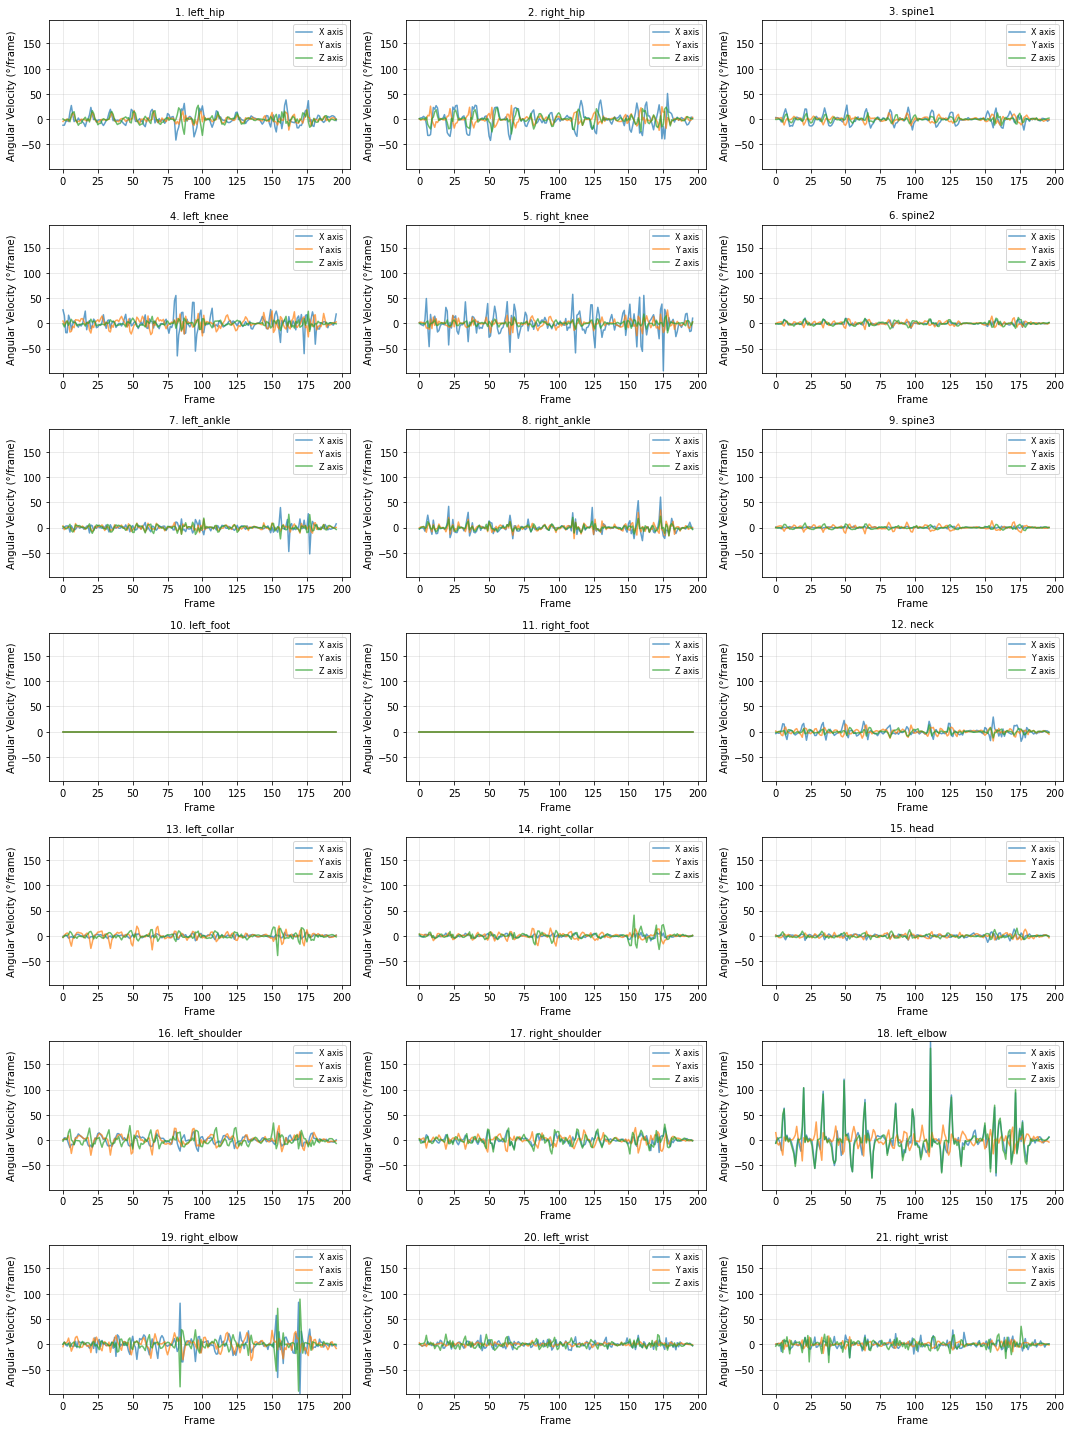

In [10]:
# 각속도 파일 플롯
file_path = 'D:/HumanML3D-SMPL-main/HumanML3D/02_angular_velocity/0017_wushukicks001_poses_timewarp_down2_keepfps.npy'

# 데이터 로드
angular_velocity = np.load(file_path)  # (seq_len-1, 21, 3)
seq_len, num_joints, _ = angular_velocity.shape

# 관절 이름
joint_names = [
    "left_hip",       # 1
    "right_hip",      # 2
    "spine1",         # 3
    "left_knee",      # 4
    "right_knee",     # 5
    "spine2",         # 6
    "left_ankle",     # 7
    "right_ankle",    # 8
    "spine3",         # 9
    "left_foot",      # 10
    "right_foot",     # 11
    "neck",           # 12
    "left_collar",    # 13
    "right_collar",   # 14
    "head",           # 15
    "left_shoulder",  # 16
    "right_shoulder", # 17
    "left_elbow",     # 18
    "right_elbow",    # 19
    "left_wrist",     # 20
    "right_wrist"     # 21
]

# 전역 min/max 계산
global_min = angular_velocity.min()
global_max = angular_velocity.max()
print(f"전역 Min: {global_min:.3f}°/frame")
print(f"전역 Max: {global_max:.3f}°/frame")

# Figure 생성 (7행 3열 = 21개 관절)
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
axes = axes.flatten()

# 각 관절별로 플롯
for joint_idx in range(num_joints):
    ax = axes[joint_idx]
    
    # X, Y, Z축 각속도 플롯
    ax.plot(angular_velocity[:, joint_idx, 0], label='X axis', alpha=0.7)
    ax.plot(angular_velocity[:, joint_idx, 1], label='Y axis', alpha=0.7)
    ax.plot(angular_velocity[:, joint_idx, 2], label='Z axis', alpha=0.7)
    
    ax.set_title(f'{joint_idx+1}. {joint_names[joint_idx]}', fontsize=10)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Angular Velocity (°/frame)')
    ax.set_ylim(global_min, global_max)  # Y축 범위 전역 min/max로 고정
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## (임시) 일단, 다리 관절만 조절해보자

In [11]:
# 다리 관절만 남기고 나머지는 0으로 처리
import os
import glob
import numpy as np
from tqdm import tqdm

# 입력/출력 디렉토리 설정
input_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/03_angular_velocity_normalized'
output_dir = 'D:/HumanML3D-SMPL-main/HumanML3D/04_angular_velocity_legs_only'

# 출력 폴더 생성
os.makedirs(output_dir, exist_ok=True)

# 다리 관절 인덱스 (0-based)
# right_hip(0), left_hip(1), right_knee(3), left_knee(4)
leg_joints = [0, 1, 3, 4]

# 모든 파일 가져오기
input_files = sorted(glob.glob(os.path.join(input_dir, '*.npy')))
print(f"총 {len(input_files)}개 파일 처리 시작\n")

# 각 파일 처리
for input_file in tqdm(input_files, desc="Processing files"):
    try:
        # 파일명 추출
        filename = os.path.basename(input_file)
        output_file = os.path.join(output_dir, filename)
        
        # 데이터 로드
        data = np.load(input_file)  # (seq_len-1, 21, 3)
        
        # 복사본 생성 및 모든 값을 0으로 초기화
        legs_only = np.zeros_like(data)
        
        # 다리 관절만 원본 값 복사
        for joint_idx in leg_joints:
            legs_only[:, joint_idx, :] = data[:, joint_idx, :]
        
        # 저장
        np.save(output_file, legs_only)
        
    except Exception as e:
        print(f"\n오류 발생 - {filename}: {e}")

print(f"\n처리 완료!")
print(f"저장 위치: {output_dir}")

# 검증: 첫 번째 파일 확인
if len(input_files) > 0:
    sample_original = np.load(input_files[0])
    sample_legs_only = np.load(os.path.join(output_dir, os.path.basename(input_files[0])))
    
    print(f"\n=== 검증: {os.path.basename(input_files[0])} ===")
    print(f"원본 shape: {sample_original.shape}")
    print(f"다리만 shape: {sample_legs_only.shape}")
    
    joint_names = [
        "right_hip", "left_hip", "spine1", "right_knee", "left_knee",
        "spine2", "right_ankle", "left_ankle", "spine3", "right_foot",
        "right_foot", "neck", "right_collar", "left_collar", "head",
        "right_shoulder", "left_shoulder", "right_elbow", "left_elbow",
        "right_wrist", "left_wrist"
    ]
    
    print(f"\n관절별 데이터 확인:")
    for joint_idx in range(21):
        mean_val = sample_legs_only[:, joint_idx, :].mean()
        status = "✓ 유지" if joint_idx in leg_joints else "✗ 제로"
        print(f"  {joint_idx:2d}. {joint_names[joint_idx]:<20} 평균: {mean_val:.6f}  {status}")

Processing files:   0%|          | 7/1584 [00:00<00:23, 66.30it/s]

총 1584개 파일 처리 시작



Processing files: 100%|██████████| 1584/1584 [00:13<00:00, 114.49it/s]


처리 완료!
저장 위치: D:/HumanML3D-SMPL-main/HumanML3D/04_angular_velocity_legs_only

=== 검증: 0003_treadmill_jog_poses_timewarp_down2_keepfps.npy ===
원본 shape: (141, 21, 3)
다리만 shape: (141, 21, 3)

관절별 데이터 확인:
   0. right_hip            평균: 0.487914  ✓ 유지
   1. left_hip             평균: 0.487025  ✓ 유지
   2. spine1               평균: 0.000000  ✗ 제로
   3. right_knee           평균: 0.518402  ✓ 유지
   4. left_knee            평균: 0.518037  ✓ 유지
   5. spine2               평균: 0.000000  ✗ 제로
   6. right_ankle          평균: 0.000000  ✗ 제로
   7. left_ankle           평균: 0.000000  ✗ 제로
   8. spine3               평균: 0.000000  ✗ 제로
   9. right_foot           평균: 0.000000  ✗ 제로
  10. right_foot           평균: 0.000000  ✗ 제로
  11. neck                 평균: 0.000000  ✗ 제로
  12. right_collar         평균: 0.000000  ✗ 제로
  13. left_collar          평균: 0.000000  ✗ 제로
  14. head                 평균: 0.000000  ✗ 제로
  15. right_shoulder       평균: 0.000000  ✗ 제로
  16. left_shoulder        평균: 0.000000  ✗ 제로
  17. right_elb

파일: 0017_wushukicks001_poses_timewarp_down2_keepfps.npy
데이터 shape: (197, 21, 3)
전체 범위: [0.000000, 0.847394]
전체 평균: 0.095696

관절                   상태              Min        Max       Mean        Std
right_hip            ✓ 유지       0.103171   0.842388   0.486872   0.088255
left_hip             ✓ 유지       0.137592   0.847394   0.486837   0.116766
spine1               ✗ 제로       0.000000   0.000000   0.000000   0.000000
right_knee           ✓ 유지       0.240057   0.823224   0.517983   0.064461
left_knee            ✓ 유지       0.095392   0.834516   0.517925   0.072954
spine2               ✗ 제로       0.000000   0.000000   0.000000   0.000000
right_ankle          ✗ 제로       0.000000   0.000000   0.000000   0.000000
left_ankle           ✗ 제로       0.000000   0.000000   0.000000   0.000000
spine3               ✗ 제로       0.000000   0.000000   0.000000   0.000000
right_foot           ✗ 제로       0.000000   0.000000   0.000000   0.000000
left_foot            ✗ 제로       0.000000   0.000000   0.00000

c:\Users\Velab\anaconda3\envs\torch_render\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Velab\anaconda3\envs\torch_render\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Velab\anaconda3\envs\torch_render\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Velab\anaconda3\envs\torch_render\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Velab\anaconda3\envs\torch_render\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\Velab\anaconda3\envs\torch_r

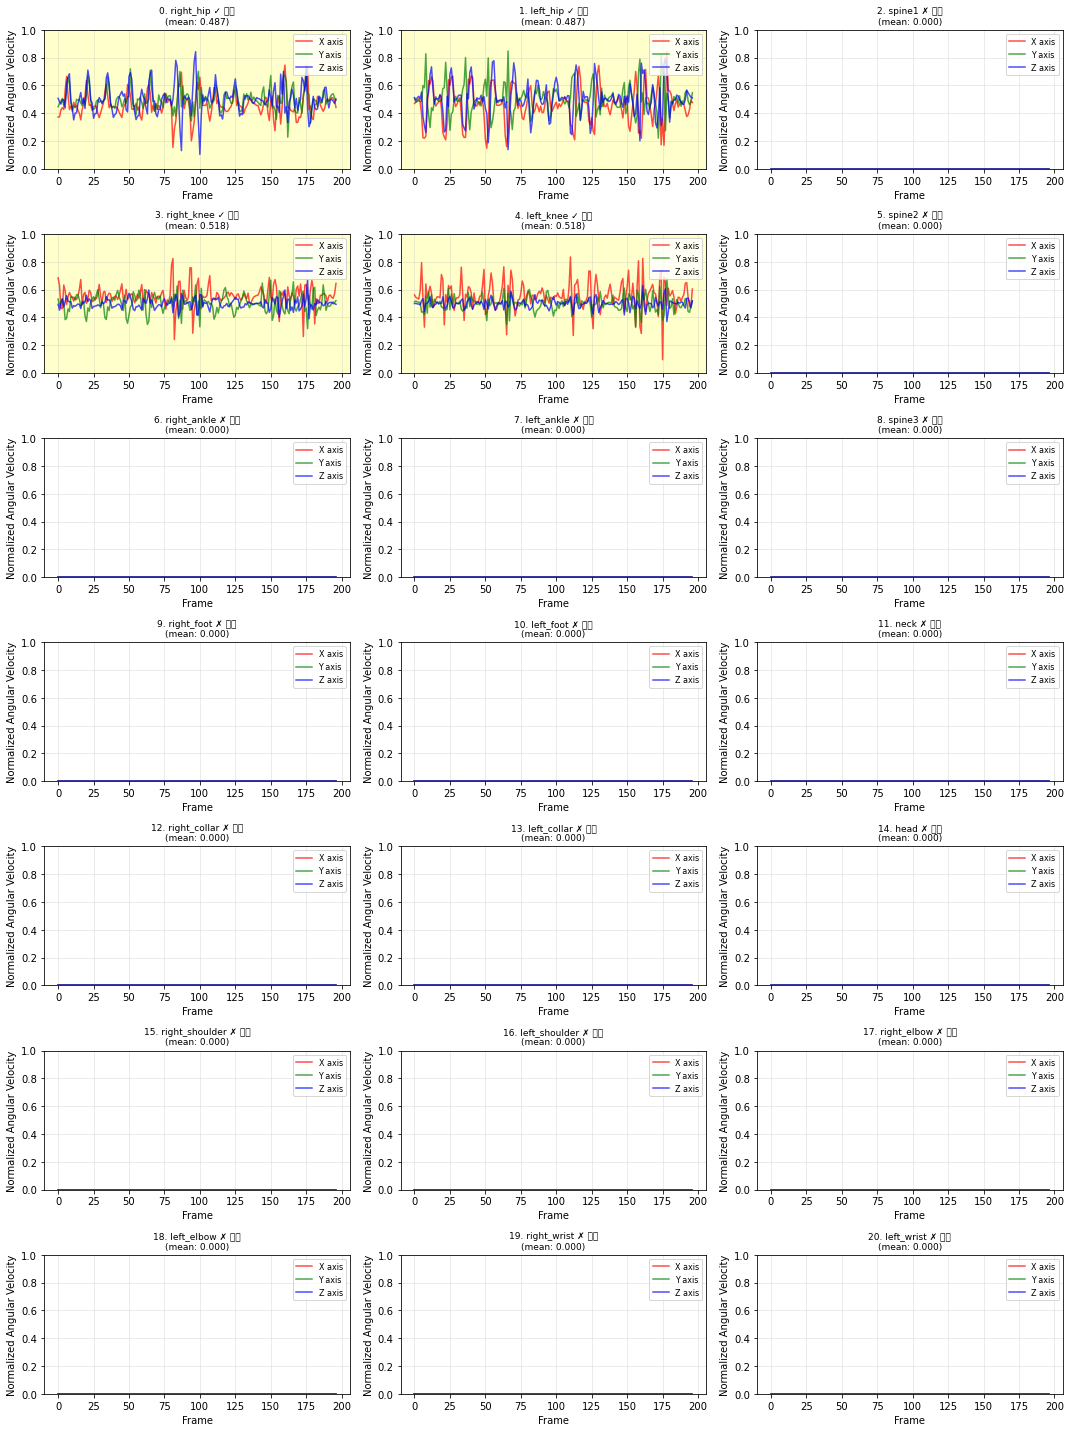

In [12]:
# 다리 관절만 남긴 파일 확인 및 플롯
import matplotlib.pyplot as plt
import numpy as np
import os

file_path = 'D:/HumanML3D-SMPL-main/HumanML3D/04_angular_velocity_legs_only/0017_wushukicks001_poses_timewarp_down2_keepfps.npy'

# 데이터 로드
legs_only = np.load(file_path)  # (seq_len-1, 21, 3)
seq_len, num_joints, _ = legs_only.shape

# 관절 이름
joint_names = [
    "right_hip",      # 0
    "left_hip",       # 1
    "spine1",         # 2
    "right_knee",     # 3
    "left_knee",      # 4
    "spine2",         # 5
    "right_ankle",    # 6
    "left_ankle",     # 7
    "spine3",         # 8
    "right_foot",     # 9
    "left_foot",      # 10
    "neck",           # 11
    "right_collar",   # 12
    "left_collar",    # 13
    "head",           # 14
    "right_shoulder", # 15
    "left_shoulder",  # 16
    "right_elbow",    # 17
    "left_elbow",     # 18
    "right_wrist",    # 19
    "left_wrist"      # 20
]

# 다리 관절 인덱스
leg_joints = [0, 1, 3, 4]

print(f"파일: {os.path.basename(file_path)}")
print(f"데이터 shape: {legs_only.shape}")
print(f"전체 범위: [{legs_only.min():.6f}, {legs_only.max():.6f}]")
print(f"전체 평균: {legs_only.mean():.6f}\n")

# 관절별 상세 통계
print("="*90)
print(f"{'관절':<20} {'상태':<8} {'Min':>10} {'Max':>10} {'Mean':>10} {'Std':>10}")
print("="*90)

for joint_idx in range(num_joints):
    joint_data = legs_only[:, joint_idx, :]  # (seq_len-1, 3)
    min_val = joint_data.min()
    max_val = joint_data.max()
    mean_val = joint_data.mean()
    std_val = joint_data.std()
    
    status = "✓ 유지" if joint_idx in leg_joints else "✗ 제로"
    
    print(f"{joint_names[joint_idx]:<20} {status:<8} {min_val:>10.6f} {max_val:>10.6f} {mean_val:>10.6f} {std_val:>10.6f}")

# Figure 생성 (7행 3열 = 21개 관절)
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
axes = axes.flatten()

# 각 관절별로 플롯
for joint_idx in range(num_joints):
    ax = axes[joint_idx]
    
    joint_data = legs_only[:, joint_idx, :]
    
    # X, Y, Z축 정규화된 각속도 플롯
    ax.plot(legs_only[:, joint_idx, 0], label='X axis', alpha=0.7, color='red')
    ax.plot(legs_only[:, joint_idx, 1], label='Y axis', alpha=0.7, color='green')
    ax.plot(legs_only[:, joint_idx, 2], label='Z axis', alpha=0.7, color='blue')
    
    # 다리 관절 여부 표시
    status = "✓ 유지" if joint_idx in leg_joints else "✗ 제로"
    
    # 제목에 통계 추가
    ax.set_title(f'{joint_idx}. {joint_names[joint_idx]} {status}\n(mean: {joint_data.mean():.3f})', fontsize=9)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Normalized Angular Velocity')
    ax.set_ylim(0, 1)  # Y축 범위 0~1로 고정 (정규화됨)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # 다리 관절은 배경색 강조
    if joint_idx in leg_joints:
        ax.set_facecolor('#ffffcc')  # 연한 노란색

plt.tight_layout()
plt.show()